### Risk score calculation

The final assessment on the resilience of the air traffic network against potential sudden
disruptive events like natural catastrophes or epidemics at
different spatial scales will be based on the so-called **risk score**
calculation for each country or world region. The comparison
of countries will be based on the risk score (RS), which is
defined as follows:

$$
RS = \frac{(1 - ORPC_N) + (1 - A_N) + VR}{3} \cdot 100,
$$
where:
- \( ORPC_N \) represents the Outgoing Routes Per Capita normalized,
- \( A_N \) represents the Airports per country normalized,
- \( VR \) represents the Visa Restriction score.

The domains for each variable are given by:
- \( RS \in (0, 100] \),
- \( ORPC_N \in (0, 1] \),
- \( A_N \in (0, 1] \),
- \( VR \in (0, 1] \).

In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#### Reading in the data

In [2]:
airports = pd.read_csv('EXPORTED_DATA/nodes.csv').rename(columns={'Unnamed: 0':'id'})
routes = pd.read_csv('EXPORTED_DATA/edges.csv')
geo_df = gpd.read_file('EXPORTED_DATA/UN_geodata.geojson')

#### Data preprocessing

All of the further calculations rely on a rather major simplification that we only look at routes where source country is not the destination country as well, meaning that we only consider routes that take passengers away from a certain country/region.

Adding source and destination country ISO codes to routes to filter out within-country flights.

In [3]:
#Adding source ISO code
routes = routes.merge(airports[['id', 'iso']], left_on='source', right_on='id', how='left')
routes.rename(columns={'iso': 'source_iso'}, inplace=True)
routes.drop('id', axis=1, inplace=True) 

#Adding destination ISO code
routes = routes.merge(airports[['id', 'iso']], left_on='destination', right_on='id', how='left')
routes.rename(columns={'iso': 'destination_iso'}, inplace=True)
routes.drop('id', axis=1, inplace=True)  # Clean up extra column

In [4]:
routes.shape

(36816, 12)

In [5]:
#Keeping only the international routes
routes_int = routes[routes['source_iso'] != routes['destination_iso']]
routes_int.shape

(19683, 12)

Now also only keep the airports that can be found among the source airports in the filtered routes dataset.

In [6]:
airports.shape

(3147, 10)

In [7]:
airports_int = airports[airports['id'].isin(routes_int['source'])]
airports_int.shape

(1213, 10)

### Countries

### Outgoing Routes Per Capita normalized

Following metric is calculated using the 2014 population value. 

**NB!** Currently the airplane capacity is not taken into account!

In [8]:
geo_df['outgoing_routes'] = None
geo_df['or_per_capita_2014'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'outgoing_routes'] = len(routes_int[routes_int['source_iso'] == country])
    geo_df.loc[geo_df['Country Code'] == country, 'or_per_capita_2014'] = len(routes_int[routes_int['source_iso'] == country]) /  geo_df.loc[geo_df['Country Code'] == country, '2014']

In [9]:
from sklearn.preprocessing import QuantileTransformer

#Using a quantile transformer to avoid strongly skewed results (even after scaling)
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=100)

geo_df['orpc2014_n'] = scaler.fit_transform(geo_df[['or_per_capita_2014']]).flatten()
#geo_df['orpc2014_n'] = (geo_df['or_per_capita_2014'] - geo_df['or_per_capita_2014'].min()) / (geo_df['or_per_capita_2014'].max() - geo_df['or_per_capita_2014'].min())
geo_df['orpc2014_n'] = pd.to_numeric(geo_df['orpc2014_n'], errors='coerce')

Visualising the results.

In [10]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
geo_df.dtypes

Country Name            object
Country Code            object
2014                   float64
2022                   float64
Region                  object
IncomeGroup             object
OF Country Name         object
geometry              geometry
outgoing_routes         object
or_per_capita_2014      object
orpc2014_n             float64
dtype: object

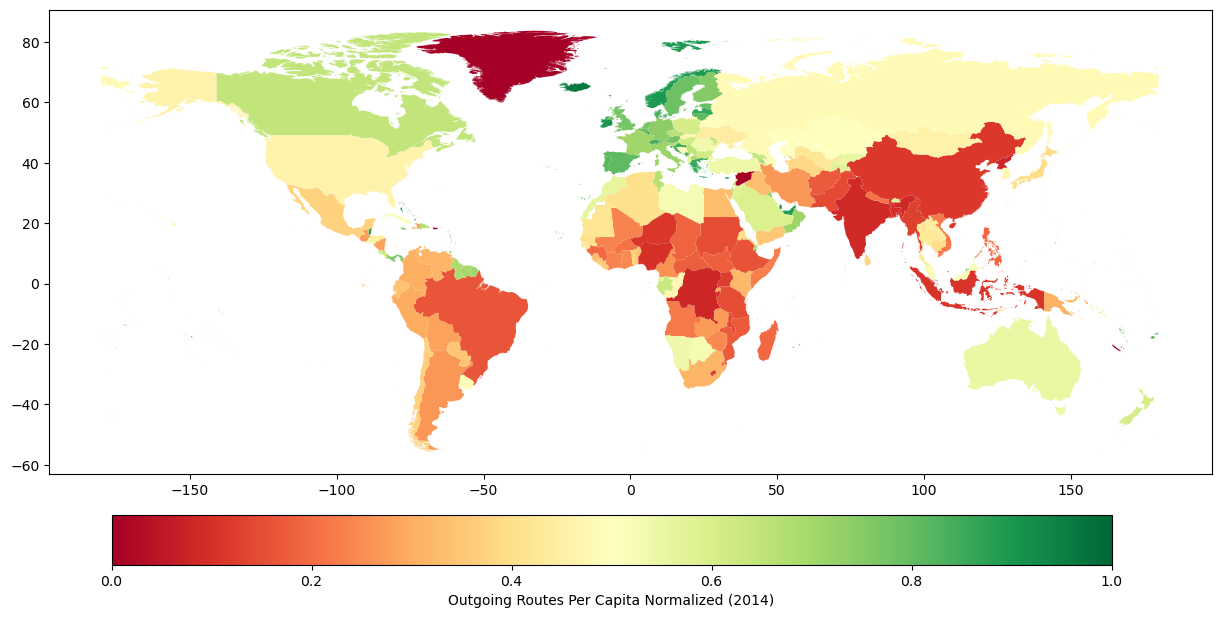

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cbar = geo_df.plot(column='orpc2014_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Outgoing Routes Per Capita Normalized (2014)",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [13]:
geo_df[geo_df['outgoing_routes'] == geo_df['outgoing_routes'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n
65,United Kingdom,GBR,64602298.0,66971395.0,Europe & Central Asia,High income,United Kingdom,"MULTIPOLYGON (((-6.28751 49.91401, -6.29727 49...",1305,0.00002,0.777028


In [14]:
geo_df[geo_df['orpc2014_n'] == geo_df['orpc2014_n'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n
148,Palau,PLW,17796.0,18055.0,East Asia & Pacific,Upper middle income,Palau,"MULTIPOLYGON (((131.81300 2.96044, 131.79518 2...",6,0.000337,1.0


### Airports per country normalized

In [15]:
invalid_geometries = geo_df[~geo_df.geometry.is_valid]

#Turns out that some of the polygons are invalid and need to be fixed in order to calculate the area properly
geo_df['geometry'] = geo_df.geometry.apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

In [16]:
print("Invalid geometries found after fixing:", geo_df[~geo_df.geometry.is_valid]) #None

Invalid geometries found after fixing: Empty GeoDataFrame
Columns: [Country Name, Country Code, 2014, 2022, Region, IncomeGroup, OF Country Name, geometry, outgoing_routes, or_per_capita_2014, orpc2014_n]
Index: []


In [17]:
#Find the areas of the countries

#Convert to an equal-area CRS
geo_df = geo_df.to_crs(epsg=6933) #Cylindrical Equal Area
#Area to square kilometers
geo_df['area_sqkm'] = geo_df.area / 1e6

geo_df = geo_df.to_crs(epsg=4326)

In [18]:
geo_df['airports'] = None
geo_df['airports_per_sqkm'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'airports'] = len(airports_int[airports_int['iso'] == country])
    geo_df.loc[geo_df['Country Code'] == country, 'airports_per_sqkm'] = len(airports_int[airports_int['iso'] == country]) /  geo_df.loc[geo_df['Country Code'] == country, 'area_sqkm']

In [19]:
from sklearn.preprocessing import QuantileTransformer

#Using a quantile transformer to avoid strongly skewed results (even after scaling)
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=100)

geo_df['apsqkm_n'] = scaler.fit_transform(geo_df[['airports_per_sqkm']]).flatten()
geo_df['apsqkm_n'] = pd.to_numeric(geo_df['apsqkm_n'], errors='coerce')

In [20]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

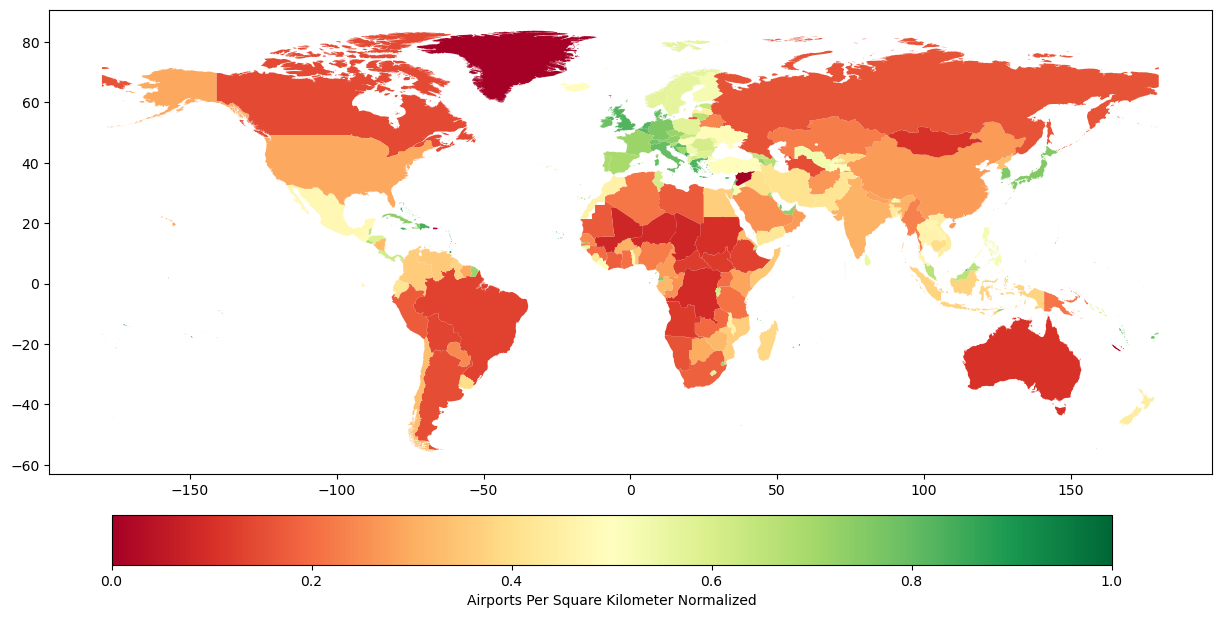

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='apsqkm_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Airports Per Square Kilometer Normalized",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [22]:
geo_df[geo_df['airports'] == geo_df['airports'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n
194,United States,USA,318386329.0,333287557.0,North America,High income,United States,"MULTIPOLYGON (((179.67140 51.87718, 179.64210 ...",1078,0.000003,0.462389,9.464444e+06,65,0.000007,0.29278


In [23]:
geo_df[geo_df['apsqkm_n'] == geo_df['apsqkm_n'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n
189,Tuvalu,TUV,10899.0,11312.0,East Asia & Pacific,Upper middle income,Tuvalu,"MULTIPOLYGON (((179.90610 -9.41863, 179.90528 ...",1,0.000092,0.946975,23.018376,1,0.043444,1.0


### Visa Restriction

In [24]:
geo_df['avg_visa_restriction'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'avg_visa_restriction'] = np.sum(routes_int.loc[routes_int['source_iso'] == country, 'visa_inv']) / len(routes_int[routes_int['source_iso'] == country])

geo_df['avg_visa_restriction'] = pd.to_numeric(geo_df['avg_visa_restriction'], errors='coerce')

C:\Users\annilo\AppData\Local\Temp\ipykernel_17244\2196141166.py:4: RuntimeWarning: invalid value encountered in double_scalars
  geo_df.loc[geo_df['Country Code'] == country, 'avg_visa_restriction'] = np.sum(routes_int.loc[routes_int['source_iso'] == country, 'visa_inv']) / len(routes_int[routes_int['source_iso'] == country])


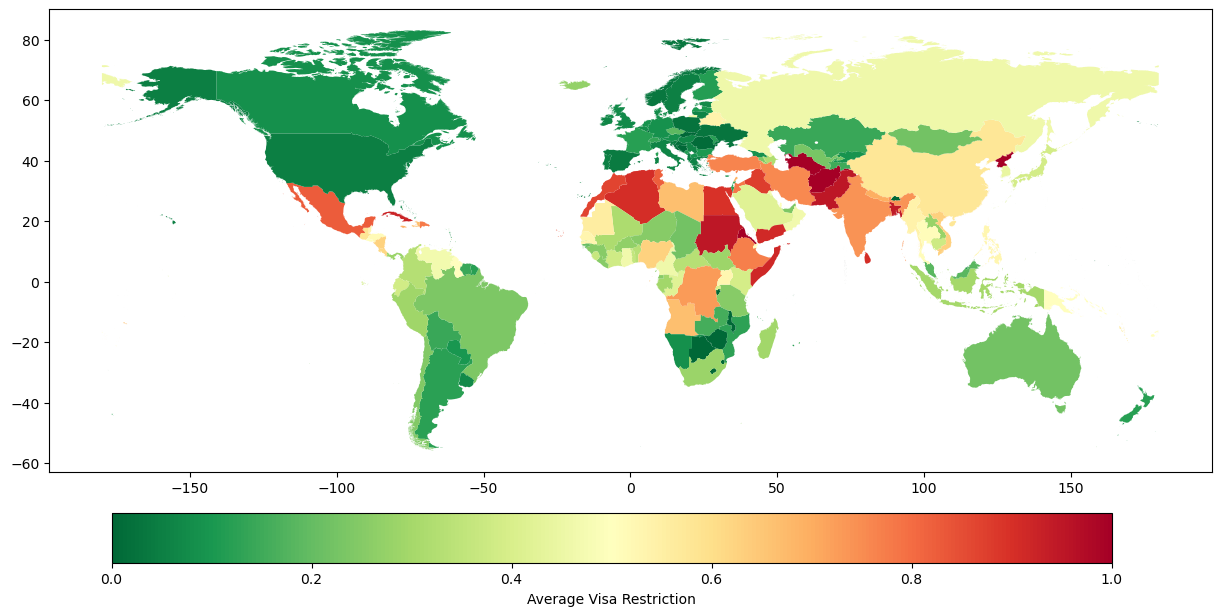

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='avg_visa_restriction', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Average Visa Restriction",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [26]:
geo_df[geo_df['avg_visa_restriction'] == geo_df['avg_visa_restriction'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
1,Afghanistan,AFG,32716210.0,41128771.0,South Asia,Low income,Afghanistan,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38...",20,0.000001,0.169873,642181.141487,4,0.000006,0.265276,1.0
55,Eritrea,ERI,3323425.0,3684032.0,Sub-Saharan Africa,Low income,Eritrea,"MULTIPOLYGON (((40.02622 15.88264, 40.06267 15...",7,0.000002,0.397355,122537.888963,1,0.000008,0.334039,1.0
152,"Korea, Dem. People's Rep.",PRK,25126131.0,26069416.0,East Asia & Pacific,Low income,North Korea,"MULTIPOLYGON (((125.31275 37.74140, 125.29575 ...",4,0.0,0.081923,122379.346211,1,0.000008,0.334778,1.0
183,Turkmenistan,TKM,5663152.0,6430770.0,Europe & Central Asia,Upper middle income,Turkmenistan,"MULTIPOLYGON (((53.10206 38.75507, 53.09474 38...",11,0.000002,0.384070,470849.123915,1,0.000002,0.148574,1.0


In [27]:
geo_df[geo_df['avg_visa_restriction'] == geo_df['avg_visa_restriction'].min()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
12,Burundi,BDI,10494913.0,12889576.0,Sub-Saharan Africa,Low income,Burundi,"MULTIPOLYGON (((30.41507 -2.31309, 30.41848 -2...",3,0.0,0.101452,27041.228345,1,0.000037,0.597309,0.0
20,Bosnia and Herzegovina,BIH,3571068.0,3233526.0,Europe & Central Asia,Upper middle income,Bosnia and Herzegovina,"MULTIPOLYGON (((16.94153 45.24122, 16.94732 45...",15,0.000004,0.491602,51826.708347,3,0.000058,0.703339,0.0
28,Bhutan,BTN,736357.0,782455.0,South Asia,Lower middle income,Bhutan,"MULTIPOLYGON (((90.26180 28.33535, 90.26180 28...",5,0.000007,0.589677,40365.396408,1,0.000025,0.535470,0.0
29,Botswana,BWA,2260376.0,2630296.0,Sub-Saharan Africa,Upper middle income,Botswana,"MULTIPOLYGON (((25.25978 -17.79411, 25.21937 -...",11,0.000005,0.523999,579029.287274,4,0.000007,0.297505,0.0
49,Dominica,DMA,69371.0,72737.0,Latin America & Caribbean,Upper middle income,Dominica,"MULTIPOLYGON (((-61.36286 15.20181, -61.37409 ...",8,0.000115,0.970255,730.311955,1,0.001369,0.906930,0.0
63,"Micronesia, Fed. Sts.",FSM,109024.0,114164.0,East Asia & Pacific,Lower middle income,Micronesia,"MULTIPOLYGON (((154.81764 0.92219, 154.81284 0...",5,0.000046,0.894652,633.848575,4,0.006311,0.970804,0.0
110,Lesotho,LSO,2095242.0,2305825.0,Sub-Saharan Africa,Lower middle income,Lesotho,"MULTIPOLYGON (((28.98085 -28.90904, 28.99542 -...",1,0.0,0.131994,30106.435505,1,0.000033,0.564434,0.0
112,Luxembourg,LUX,556319.0,653103.0,Europe & Central Asia,High income,Luxembourg,"MULTIPOLYGON (((6.03863 50.14841, 6.06137 50.1...",54,0.000097,0.955014,2608.476217,1,0.000383,0.864653,0.0
120,Marshall Islands,MHL,50419.0,41569.0,East Asia & Pacific,Upper middle income,Marshall Islands,"MULTIPOLYGON (((168.71681 4.57477, 168.68539 4...",5,0.000099,0.959998,164.814334,2,0.012135,0.980215,0.0
131,Malawi,MWI,16477966.0,20405317.0,Sub-Saharan Africa,Low income,Malawi,"MULTIPOLYGON (((34.71161 -12.12081, 34.68897 -...",8,0.0,0.141415,119397.803386,2,0.000017,0.454369,0.0


### Risk score

In [28]:
geo_df['risk_score'] = (((1 - geo_df['orpc2014_n']) + (1 - geo_df['apsqkm_n']) + geo_df['avg_visa_restriction']) / 3) * 100

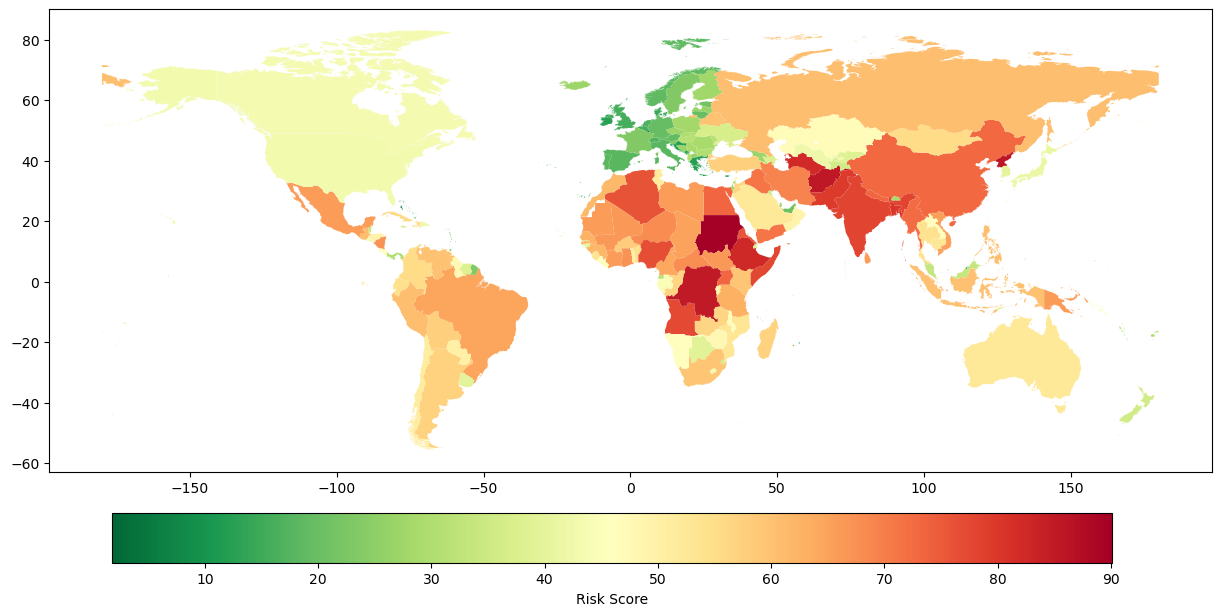

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='risk_score', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Risk Score",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

Classifying the countries to three risk classes - low, medium and high.

In [30]:
bins = [0, 30, 60, 100]
labels = ['low', 'medium', 'high']

geo_df['risk_class'] = pd.cut(geo_df['risk_score'], bins=bins, labels=labels, right=False)

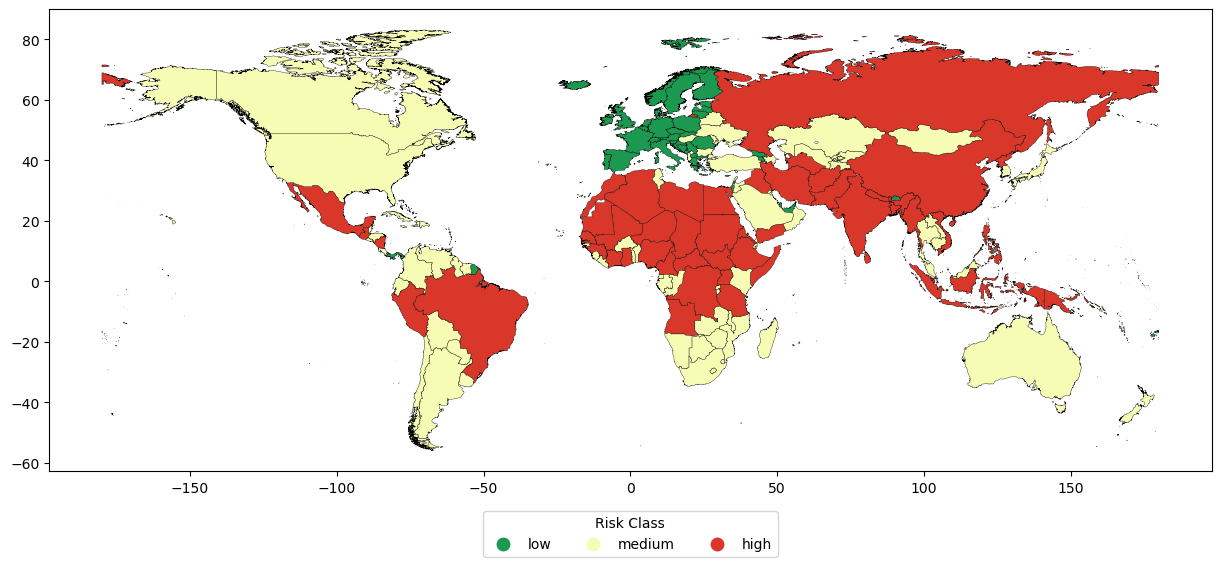

In [31]:
from matplotlib.colors import ListedColormap

color_dict = {
    'Low': '#1b9950',
    'Medium': '#f7fcb4',
    'High': '#da372b'
}

cmap = ListedColormap([color_dict[x] for x in color_dict.keys()])

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot = geo_df.plot(column='risk_class', ax=ax, cmap=cmap, legend=True,
                   legend_kwds={'title': "Risk Class", 'loc': 'lower center',
                                'bbox_to_anchor': (0.5, -0.2), 'ncol': len(color_dict)},
            edgecolor='black', linewidth=0.25)

plt.show()

### Income group averages

Inspecting how well does the income group correlate with the risk score estimate.

In [32]:
geo_df['IncomeGroup'].unique()

array(['High income', 'Low income', 'Lower middle income',
       'Upper middle income', None], dtype=object)

In [33]:
income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

print("Average risk scores per income group:\n")
for group in income_order:
    print(f"{group}: {round(geo_df.loc[geo_df['IncomeGroup'] == group, 'risk_score'].sum() / len(geo_df.loc[geo_df['IncomeGroup'] == group, 'risk_score']), 3)}")

Average risk scores per income group:

Low income: 61.538
Lower middle income: 53.67
Upper middle income: 39.752
High income: 18.939


In [34]:
print("Count of risk groups per income group:\n")
for group in income_order:
    print(f"{group} ({len(geo_df[geo_df['IncomeGroup'] == group])}): (Low: {len(geo_df[(geo_df['IncomeGroup'] == group) & (geo_df['risk_class'] == 'low')])}, Medium: {len(geo_df[(geo_df['IncomeGroup'] == group) & (geo_df['risk_class'] == 'medium')])}, High: {len(geo_df[(geo_df['IncomeGroup'] == group) & (geo_df['risk_class'] == 'high')])})")

Count of risk groups per income group:

Low income (26): (Low: 0, Medium: 11, High: 14)
Lower middle income (54): (Low: 4, Medium: 27, High: 23)
Upper middle income (52): (Low: 17, Medium: 25, High: 10)
High income (73): (Low: 45, Medium: 13, High: 0)


## Regions

In [35]:
geo_df['Region'].unique()

array(['Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa',
       'Europe & Central Asia', 'Middle East & North Africa',
       'East Asia & Pacific', 'North America'], dtype=object)

For each **region** label listed in the geodataframe - 'Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia', 'Middle East & North Africa','East Asia & Pacific', 'North America' - I will create a new multipolygon based on the countries located within this region. Then a similar risk score calulation schema will be carried out as done previously, with regions being the new "countries".

In [36]:
#Adding the region label to airports

airports_int = airports_int.merge(geo_df[['Country Code', 'Region']], left_on = 'iso', right_on = 'Country Code').drop(columns='Country Code')

In [37]:
#Adding region labels to routes as well to keep only the interregional routes

#Source region
routes_int = routes_int.merge(geo_df[['Country Code', 'Region']], left_on = 'source_iso', right_on = 'Country Code').drop(columns='Country Code').rename(columns={'Region':'source_reg'})

#Destination region
routes_int = routes_int.merge(geo_df[['Country Code', 'Region']], left_on = 'destination_iso', right_on = 'Country Code').drop(columns='Country Code').rename(columns={'Region':'destination_reg'})

In [38]:
routes_int

,source,destination,airline,equipment,visa,visa_inv,source_lat,source_lon,dest_lat,dest_lon,source_iso,destination_iso,source_reg,destination_reg
0,5,3320,5360,73H,0.0,1.0,-9.443380,147.220001,-27.384199,153.117004,PNG,AUS,East Asia & Pacific,East Asia & Pacific
1,5,3322,4089,DH4,0.0,1.0,-9.443380,147.220001,-16.885799,145.755005,PNG,AUS,East Asia & Pacific,East Asia & Pacific
2,5,3361,4089,738,0.0,1.0,-9.443380,147.220001,-33.946098,151.177002,PNG,AUS,East Asia & Pacific,East Asia & Pacific
3,5435,3322,328,DH4,0.0,1.0,-4.340460,152.380005,-16.885799,145.755005,PNG,AUS,East Asia & Pacific,East Asia & Pacific
4,156,3361,330,77L,0.0,1.0,49.193901,-123.183998,-33.946098,151.177002,CAN,AUS,North America,East Asia & Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18408,3040,3155,2058,319,1.0,0.0,26.681200,88.328598,27.403200,89.424599,IND,BTN,South Asia,South Asia
18409,3043,3155,2058,ATR 319,1.0,0.0,22.654699,88.446701,27.403200,89.424599,IND,BTN,South Asia,South Asia
18410,6173,3155,2058,319,1.0,0.0,26.106100,91.585899,27.403200,89.424599,IND,BTN,South Asia,South Asia
18411,3076,3155,2058,319,1.0,0.0,23.843347,90.397783,27.403200,89.424599,BGD,BTN,South Asia,South Asia


In [39]:
#Filtering out only the interregional flights and airports
routes_reg = routes_int[routes_int['source_reg'] != routes_int['destination_reg']]
airports_reg = airports_int[airports_int['id'].isin(routes_reg['source'])]

In [40]:
print(f"International airports: {len(airports_int)}")
print(f"Interregional airports: {len(airports_reg)}")

International airports: 1102
Interregional airports: 577


In [41]:
print(f"International routes: {len(routes_int)}")
print(f"Interregional routes: {len(routes_reg)}")

International routes: 18413
Interregional routes: 5788


In [42]:
#Creating a new geodataframe for region

from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

#Ensure valid geometries
geo_df['geometry'] = geo_df['geometry'].apply(lambda geom: geom if geom.is_valid else geom.buffer(0))

def aggregate_geometries(group):
    return pd.Series({
        'geometry': unary_union(group.geometry),
        'pop_2014': group['2014'].sum(),
        'pop_2022': group['2022'].sum()
    })

region_geom = geo_df.groupby('Region').apply(aggregate_geometries).reset_index()
geo_df_reg = gpd.GeoDataFrame(region_geom, geometry = 'geometry', crs = "EPSG:4326")

In [43]:
#Adding area column

geo_df_reg = geo_df_reg.to_crs(epsg=6933) #Cylindrical Equal Area
geo_df_reg['area_sqkm'] = geo_df_reg.area / 1e6
geo_df_reg = geo_df_reg.to_crs(epsg=4326)

In [44]:
geo_df_reg

,Region,geometry,pop_2014,pop_2022,area_sqkm
0,East Asia & Pacific,"MULTIPOLYGON (((102.07311 6.25750, 102.09864 6...",2.254840e+09,2.351976e+09,2.448524e+07
1,Europe & Central Asia,"MULTIPOLYGON (((3.38258 -54.44931, 3.36451 -54...",9.005190e+08,9.182502e+08,3.006587e+07
2,Latin America & Caribbean,"MULTIPOLYGON (((-67.56766 -55.80718, -67.55191...",6.147100e+08,6.589805e+08,2.031003e+07
3,Middle East & North Africa,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12...",4.274912e+08,4.882359e+08,1.085711e+07
4,North America,"MULTIPOLYGON (((-155.60652 20.13796, -155.5863...",3.538889e+08,3.722810e+08,1.941018e+07
5,South Asia,"MULTIPOLYGON (((73.16310 -0.68182, 73.17254 -0...",1.754030e+09,1.919348e+09,5.057373e+06
6,Sub-Saharan Africa,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -...",9.815066e+08,1.211190e+09,2.393132e+07


### Outgoing Routes Per Capita normalized

Currently using population from 2014.

In [45]:
geo_df_reg['outgoing_routes'] = None
geo_df_reg['or_per_capita_2014'] = None

for region in geo_df_reg['Region']:
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'outgoing_routes'] = len(routes_reg[routes_reg['source_reg'] == region])
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'or_per_capita_2014'] = len(routes_reg[routes_reg['source_reg'] == region]) /  geo_df_reg.loc[geo_df_reg['Region'] == region, 'pop_2014']

In [46]:
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=3)

geo_df_reg['orpc2014_n'] = scaler.fit_transform(geo_df_reg[['or_per_capita_2014']]).flatten()
geo_df_reg['orpc2014_n'] = pd.to_numeric(geo_df_reg['orpc2014_n'], errors='coerce')

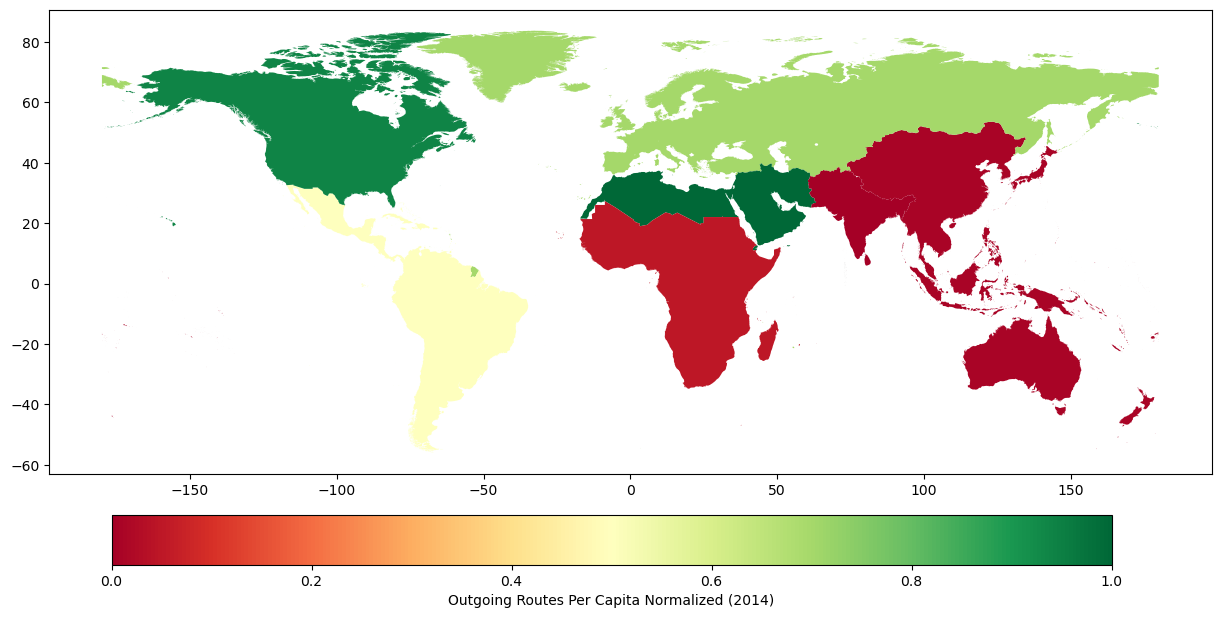

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cbar = geo_df_reg.plot(column='orpc2014_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Outgoing Routes Per Capita Normalized (2014)",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

### Airports per region normalized

In [48]:
airports_reg

,id,name,city,country,region,iso,iata,icao,lat,lon,Region
2,16,Keflavik International Airport,Keflavik,Iceland,Europe & Central Asia,ISL,KEF,BIKF,63.985001,-22.605600,Europe & Central Asia
4,8209,Vinnytsia/Gavyryshivka Airport,Vinnitsa,Ukraine,Europe & Central Asia,UKR,VIN,UKWW,49.242531,28.613778,Europe & Central Asia
5,2939,Boryspil International Airport,Kiev,Ukraine,Europe & Central Asia,UKR,KBP,UKBB,50.345001,30.894699,Europe & Central Asia
6,2940,Donetsk International Airport,Donetsk,Ukraine,Europe & Central Asia,UKR,DOK,UKCC,48.073601,37.739700,Europe & Central Asia
7,2941,Dnipropetrovsk International Airport,Dnepropetrovsk,Ukraine,Europe & Central Asia,UKR,DNK,UKDD,48.357201,35.100601,Europe & Central Asia
...,...,...,...,...,...,...,...,...,...,...,...
1095,4105,Hosea Kutako International Airport,Windhoek,Namibia,Sub-Saharan Africa,NAM,WDH,FYWH,-22.479900,17.470900,Sub-Saharan Africa
1097,4119,Djibouti-Ambouli Airport,Djibouti,Djibouti,Middle East & North Africa,DJI,JIB,HDAM,11.547300,43.159500,Middle East & North Africa
1098,4162,Conakry International Airport,Conakry,Guinea,Sub-Saharan Africa,GIN,CKY,GUCY,9.576890,-13.612000,Sub-Saharan Africa
1099,4304,Cheddi Jagan International Airport,Georgetown,Guyana,Latin America & Caribbean,GUY,GEO,SYCJ,6.498550,-58.254101,Latin America & Caribbean


In [49]:
geo_df_reg['airports'] = None
geo_df_reg['airports_per_sqkm'] = None

for region in geo_df_reg['Region']:
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'airports'] = len(airports_reg[airports_reg['Region'] == region])
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'airports_per_sqkm'] = len(airports_reg[airports_reg['Region'] == region]) /  geo_df_reg.loc[geo_df_reg['Region'] == region, 'area_sqkm']

In [50]:
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=3)

geo_df_reg['apsqkm_n'] = scaler.fit_transform(geo_df_reg[['airports_per_sqkm']]).flatten()
geo_df_reg['apsqkm_n'] = pd.to_numeric(geo_df_reg['apsqkm_n'], errors='coerce')

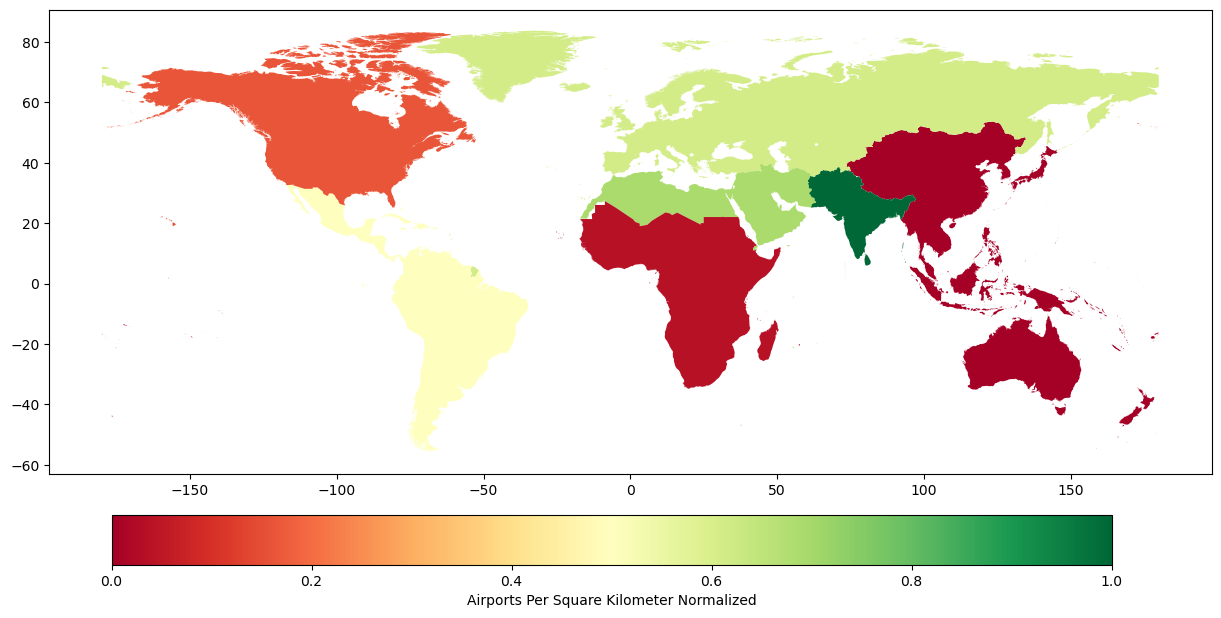

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df_reg.plot(column='apsqkm_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Airports Per Square Kilometer Normalized",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

### Visa restriction

In [52]:
geo_df_reg['avg_visa_restriction'] = None

for region in geo_df_reg['Region']:
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'avg_visa_restriction'] = np.sum(routes_reg.loc[routes_reg['source_reg'] == region, 'visa_inv']) / len(routes_reg[routes_reg['source_reg'] == region])

geo_df_reg['avg_visa_restriction'] = pd.to_numeric(geo_df_reg['avg_visa_restriction'], errors='coerce')

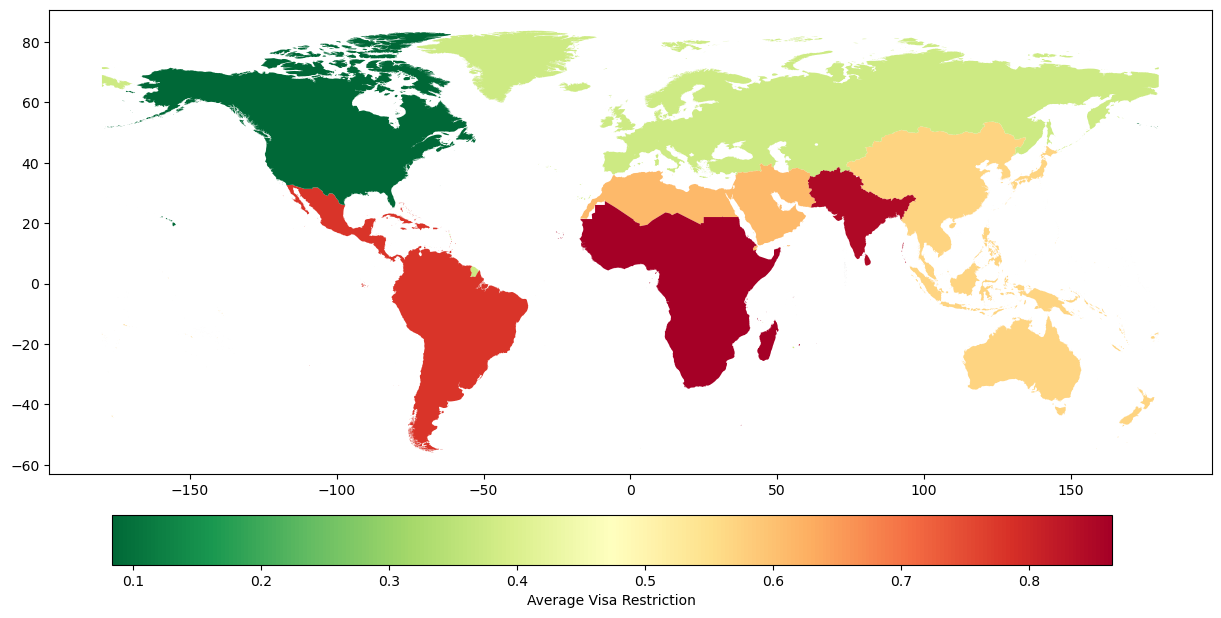

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df_reg.plot(column='avg_visa_restriction', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Average Visa Restriction",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

### Risk score

In [54]:
geo_df_reg['risk_score'] = (((1 - geo_df_reg['orpc2014_n']) + (1 - geo_df_reg['apsqkm_n']) + geo_df_reg['avg_visa_restriction']) / 3) * 100

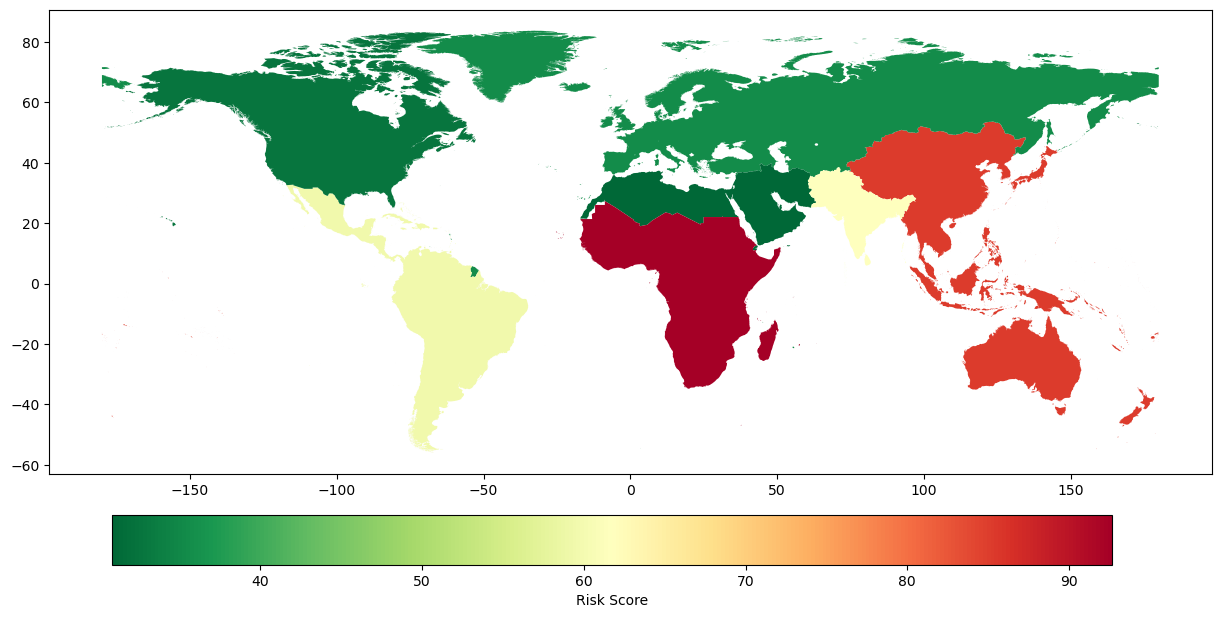

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df_reg.plot(column='risk_score', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Risk Score",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()